# Demo of calibrated explanations on the speeddating dataset
Author: Tuwe Löfström (tuwe.lofstrom@ju.se)  
Copyright 2023 Tuwe Löfström  
License: BSD 3 clause
Sources:
1. [Summary on the robustness of interpretability methods [Medium]](https://medium.com/@mohamadt/summary-on-the-robustness-of-interpretability-methods-ffb26ba22776)
2. [On the Robustness of Interpretability Methods [Arxiv]](https://arxiv.org/pdf/1806.08049.pdf)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from lime import lime_tabular
from calibrated_explanations import CalibratedAsLimeTabularExplainer, CalibratedExplainer, __version__
import pandas as pd 
import time

c:\Users\loftuw\Anaconda3\envs\cp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataSet = 'speeddating'
delimiter = ','

fileName = '../data/' + dataSet + ".csv"
df = pd.read_csv(fileName, delimiter=delimiter)
df = df.dropna()
df = df.drop(['has_null'], axis=1)
target = 'match'

In [4]:
categorical_features = []
categorical_labels = {}
for c, col in enumerate(df.columns):
    if df[col].dtype == object:
        df[col] = df[col].str.replace("'", "")
        if col != target:
            categorical_features.append(c)
            categorical_labels[c] = dict(zip(range(len(np.unique(df[col]))),np.unique(df[col])))
        mapping = dict(zip(np.unique(df[col]), range(len(np.unique(df[col])))))
        df[col] = df[col].map(mapping)
print(categorical_labels)

{1: {0: 'female', 1: 'male'}, 5: {0: '[0-1]', 1: '[2-3]', 2: '[4-6]', 3: '[7-37]'}, 6: {0: 'Asian/Pacific Islander/Asian-American', 1: 'Black/African American', 2: 'European/Caucasian-American', 3: 'Latino/Hispanic American', 4: 'Other'}, 7: {0: 'Asian/Pacific Islander/Asian-American', 1: 'Black/African American', 2: 'European/Caucasian-American', 3: 'Latino/Hispanic American', 4: 'Other'}, 8: {0: '0', 1: '1'}, 11: {0: '[0-1]', 1: '[2-5]', 2: '[6-10]'}, 12: {0: '[0-1]', 1: '[2-5]', 2: '[6-10]'}, 13: {0: 'Applied Maths/Econs', 1: 'Art History/medicine', 2: 'Biomedical Engineering', 3: 'Business', 4: 'Business & International Affairs', 5: 'Business [MBA]', 6: 'Business- MBA', 7: 'Chemistry', 8: 'Classics', 9: 'Communications', 10: 'Computer Science', 11: 'Economics', 12: 'Economics and Political Science', 13: 'Economics; Sociology', 14: 'Educational Psychology', 15: 'Electrical Engineering', 16: 'Elementary/Childhood Education [MA]', 17: 'Engineering', 18: 'English', 19: 'Film', 20: 'Fin

In [5]:
df.head()

,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,...,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,1.0,0,21.0,27.0,6.0,2,0,2,0,2.0,...,0,1,7.0,6.0,1,1,0.0,1,0,0
1,1.0,0,21.0,22.0,1.0,0,0,2,0,2.0,...,0,1,7.0,5.0,1,1,1.0,1,0,0
3,1.0,0,21.0,23.0,2.0,1,0,2,0,2.0,...,0,1,7.0,6.0,1,1,0.0,1,1,1
4,1.0,0,21.0,24.0,3.0,1,0,3,0,2.0,...,0,1,6.0,6.0,1,1,0.0,1,1,1
5,1.0,0,21.0,25.0,4.0,2,0,2,0,2.0,...,0,1,6.0,5.0,1,1,0.0,0,1,0


In [6]:
num_to_test = 20

X, y = df.drop(target,axis=1), df[target] 
no_of_classes = len(np.unique(y))
no_of_features = X.shape[1]
no_of_instances = X.shape[0]
# sort targets to make sure equal presence of both classes in test set (see definition of test_index after outer loop below)
idx = np.argsort(y.values).astype(int)
X, y = X.values[idx,:], y.values[idx]
# Select num_to_test/2 from top and num_to_test/2 from bottom of list of instances
test_index = np.array([*range(int(num_to_test/2)), *range(no_of_instances-1, no_of_instances-int(num_to_test/2)-1,-1)])
train_index = np.setdiff1d(np.array(range(no_of_instances)), test_index)   
trainCalX, X_test = X[train_index,:], X[test_index,:]
trainCalY, y_test = y[train_index], y[test_index]
# trainCalX,trainCalY = shuffle(trainCalX, trainCalY)
X_train, calX, y_train, calY = train_test_split(trainCalX, trainCalY, test_size=0.33,random_state=42, stratify=trainCalY)
print(y_test)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


In [7]:
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      1.00      0.71        10
           1       1.00      0.20      0.33        10

    accuracy                           0.60        20
   macro avg       0.78      0.60      0.52        20
weighted avg       0.78      0.60      0.52        20



In [8]:
tic = time.time()
explainer = CalibratedExplainer(model, calX, calY, 
                                    feature_names=df.columns, 
                                    categorical_features=categorical_features,
                                    categorical_labels=categorical_labels)
print(f"Time taken: {time.time()-tic}")
print(__version__)


Time taken: 0.01700115203857422
v0.0.20


In [9]:
tic = time.time()
counterfactual_explanation = explainer.explain_counterfactual(X_test)
toc = time.time()
print(f"Time taken: {toc-tic}")

Time taken: 147.60585951805115


Time taken plotting counterfactual rules: 4.01147198677063
Time taken conjunctive rules: 165.94583320617676


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Time taken plotting counterfactual and conjunctive rules: 4.350710153579712


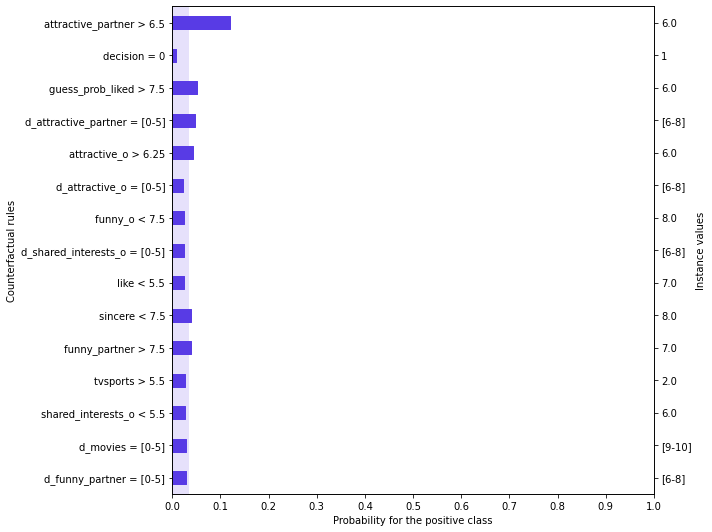

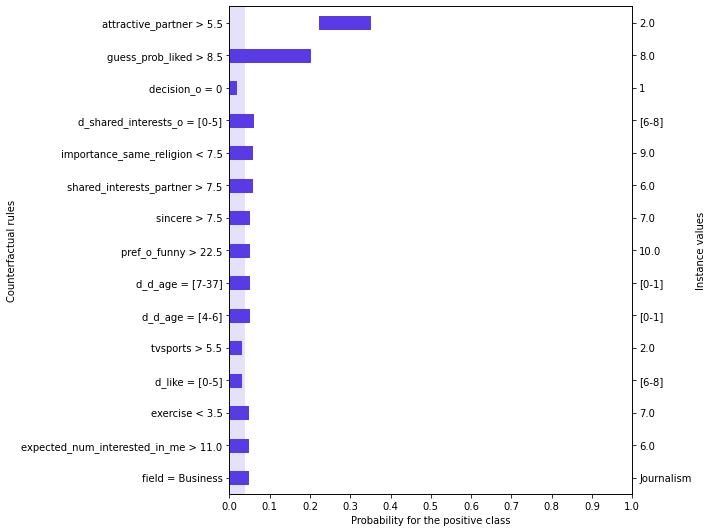

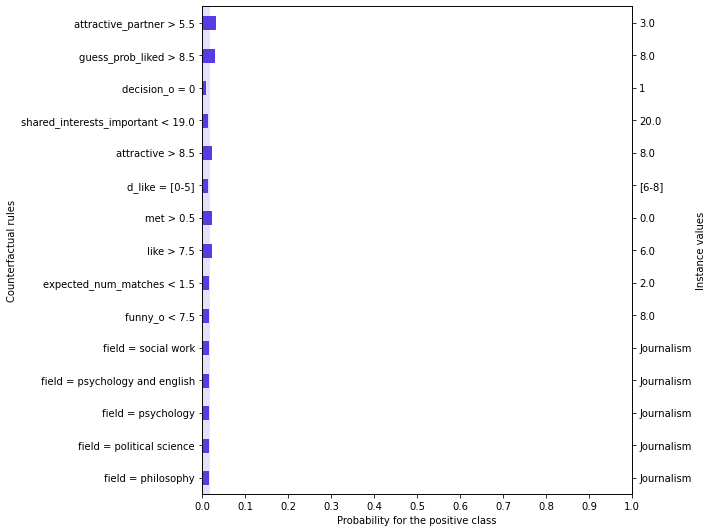

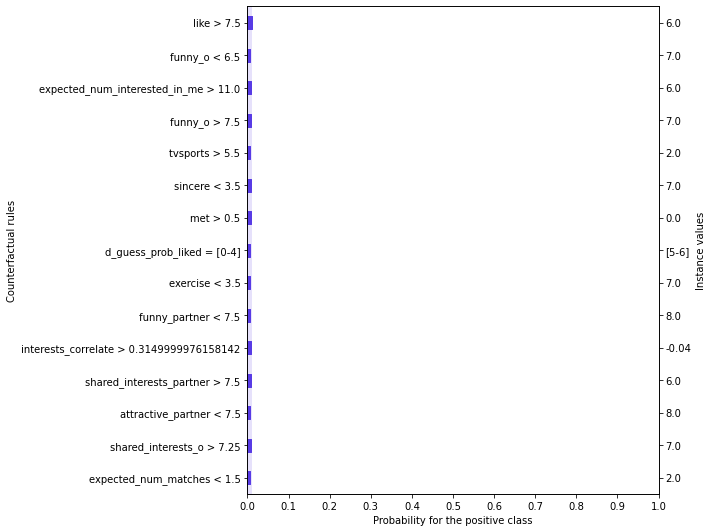

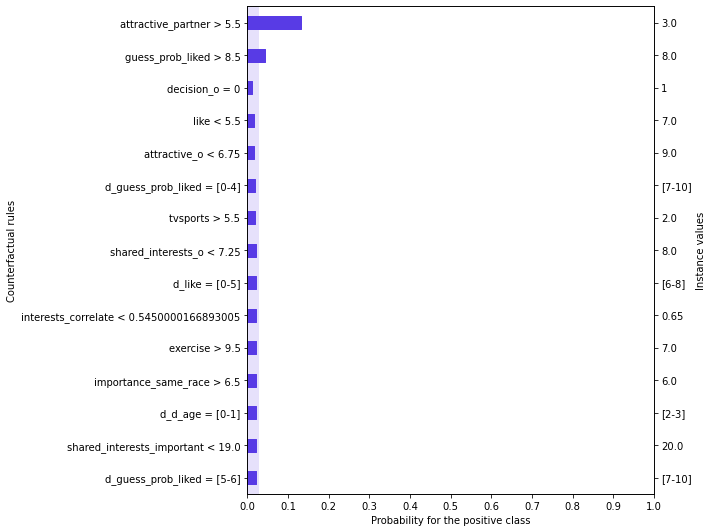

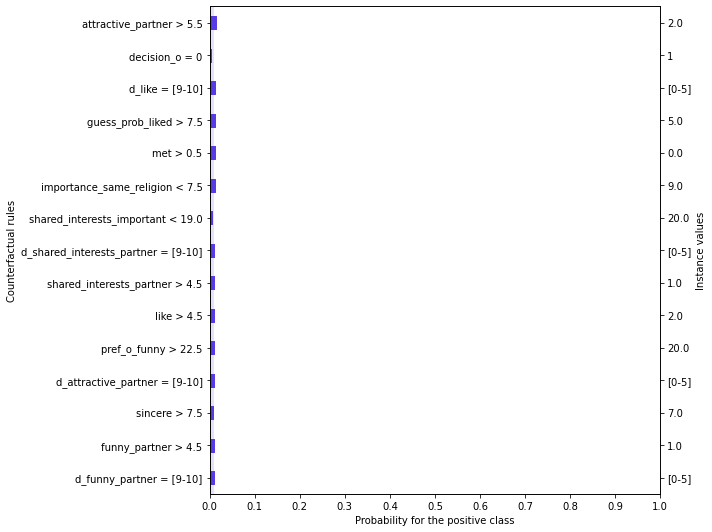

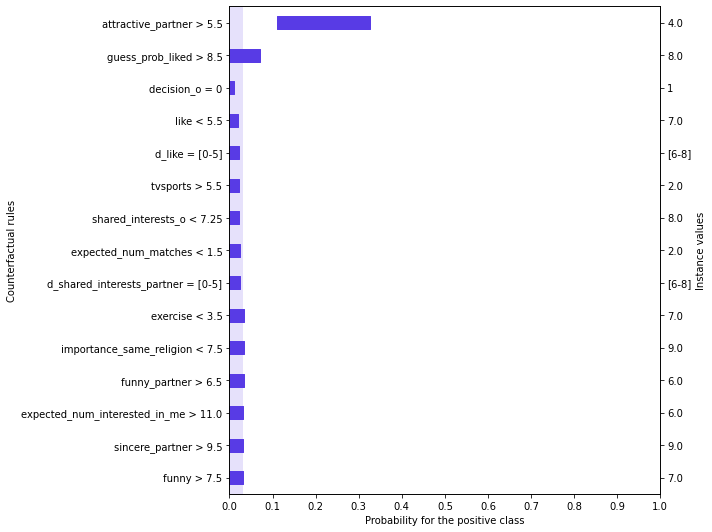

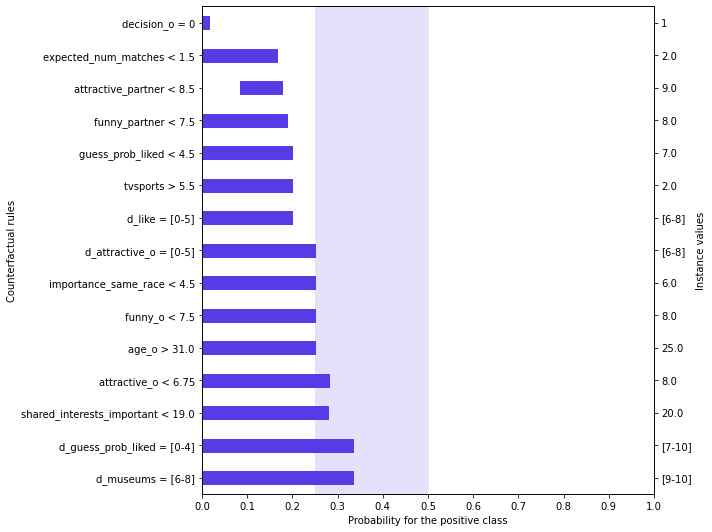

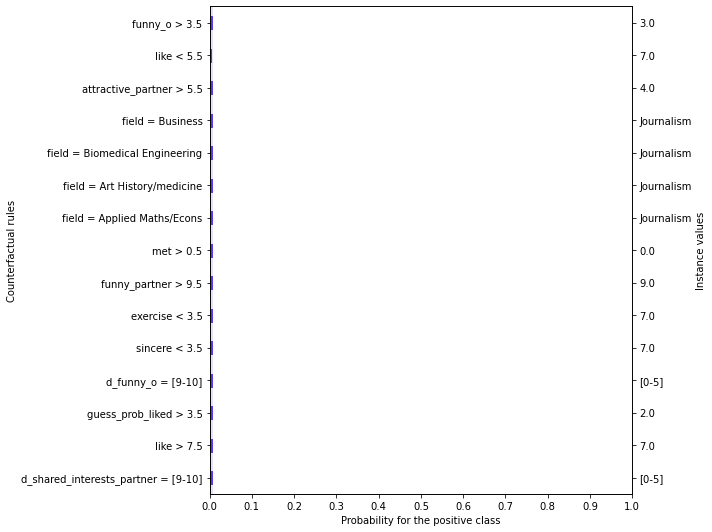

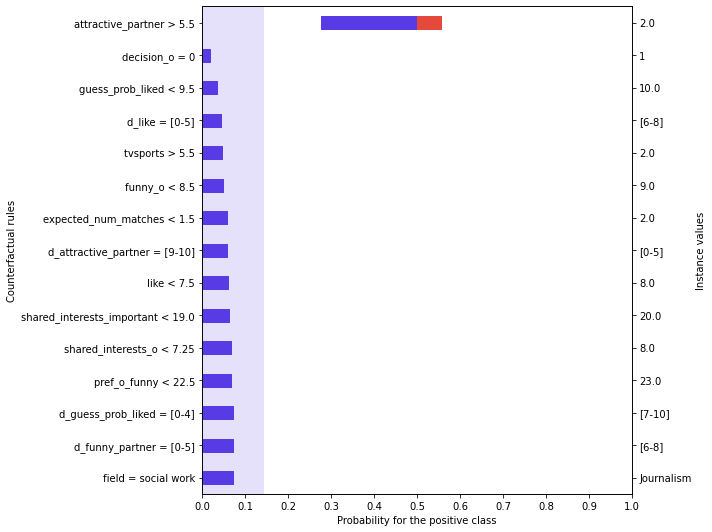

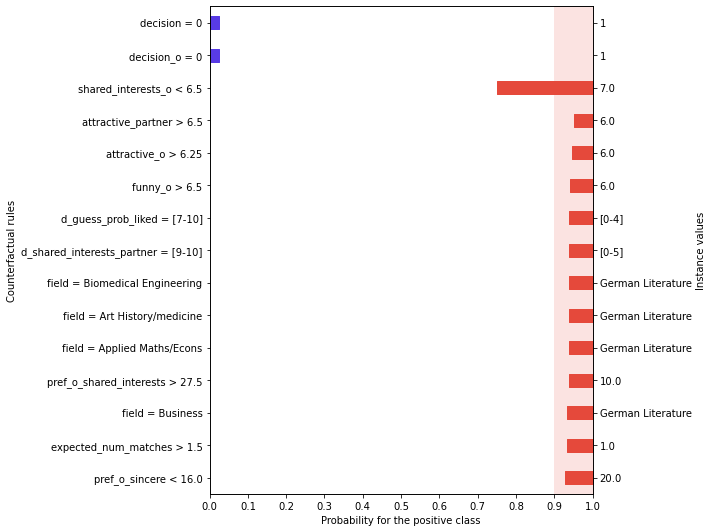

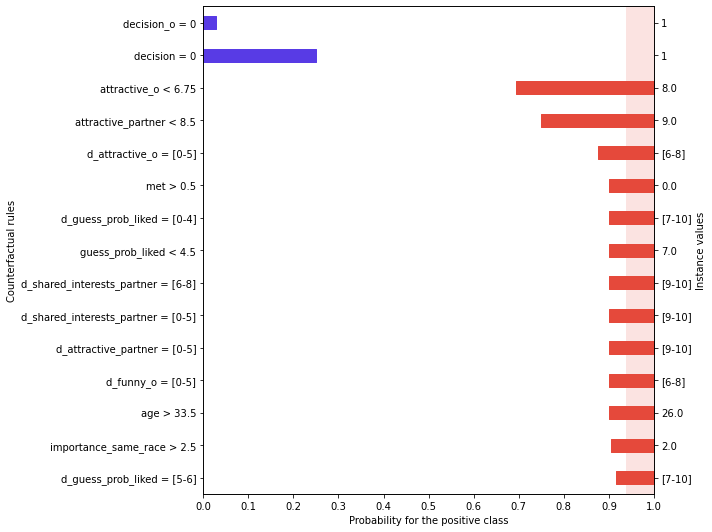

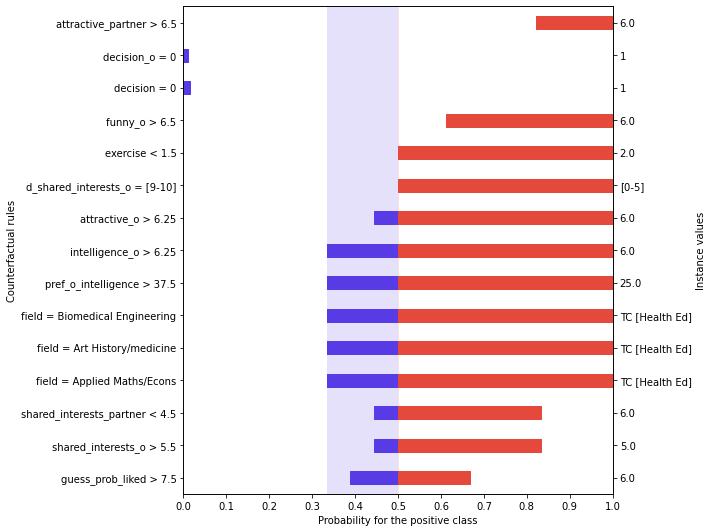

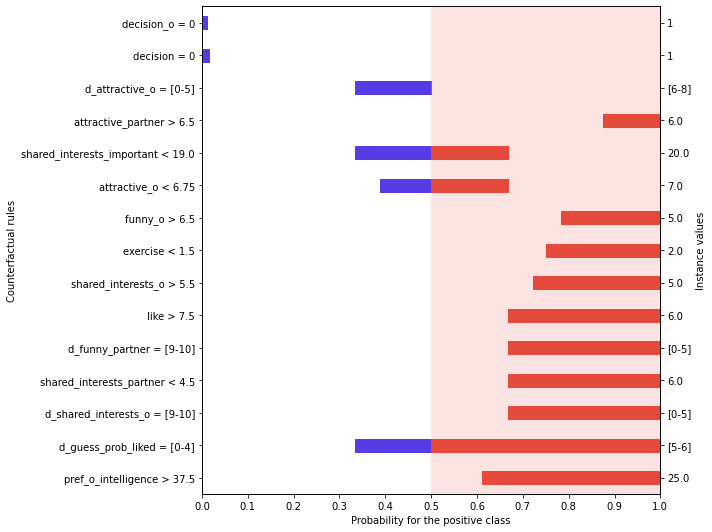

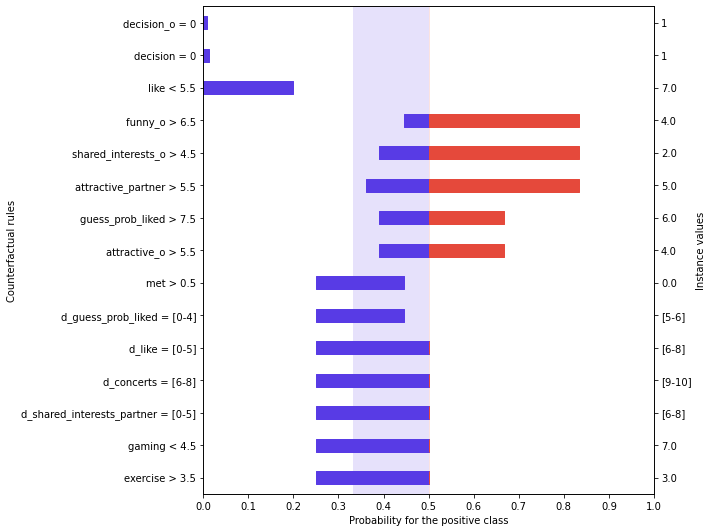

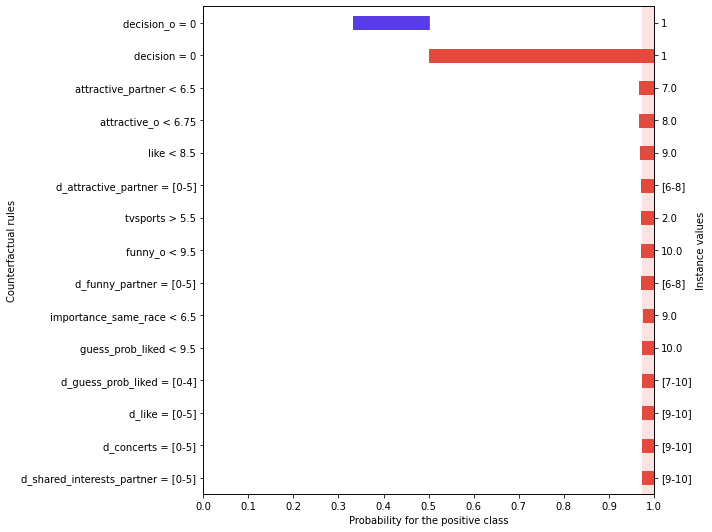

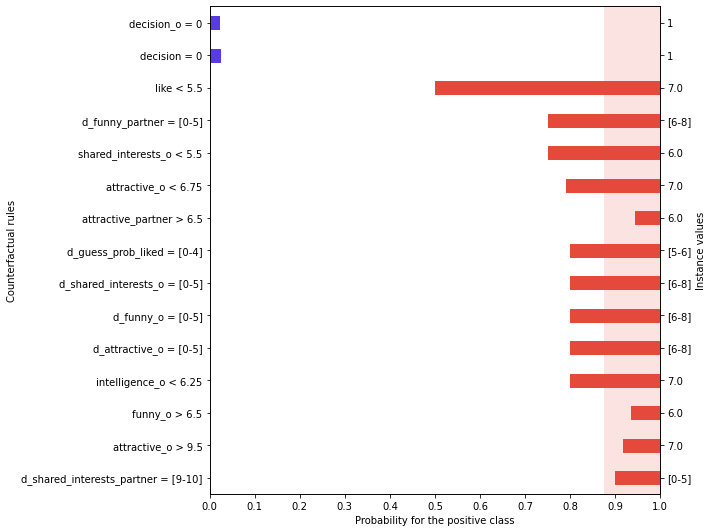

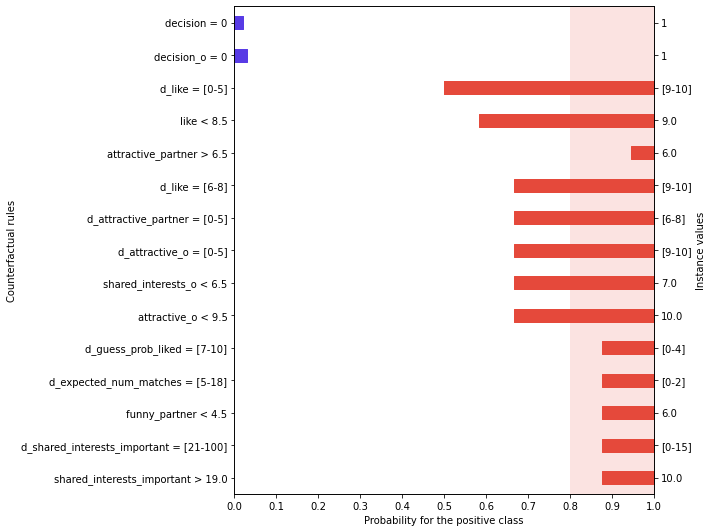

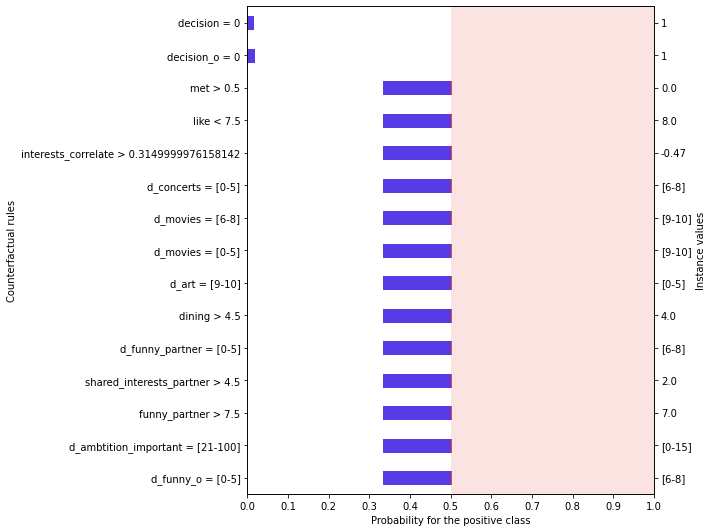

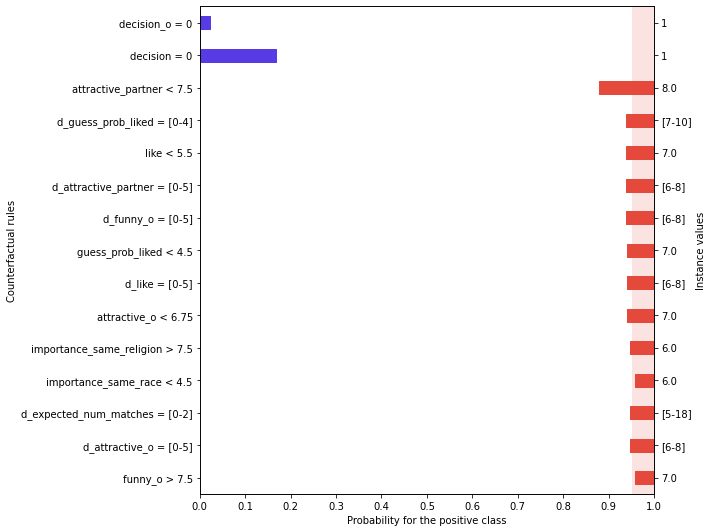

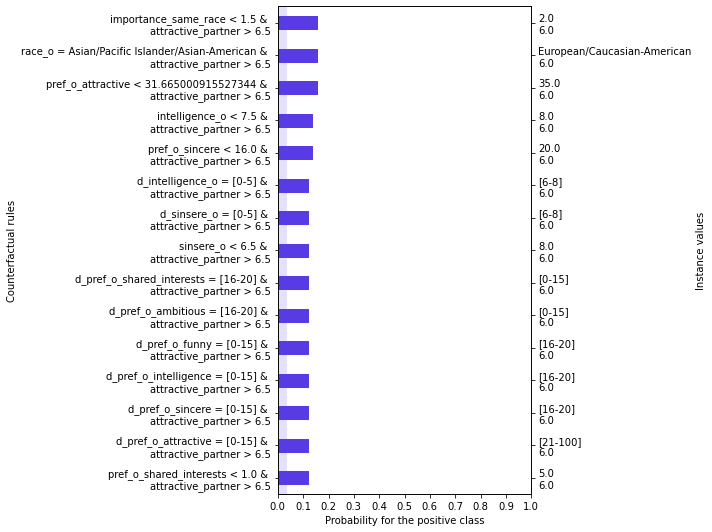

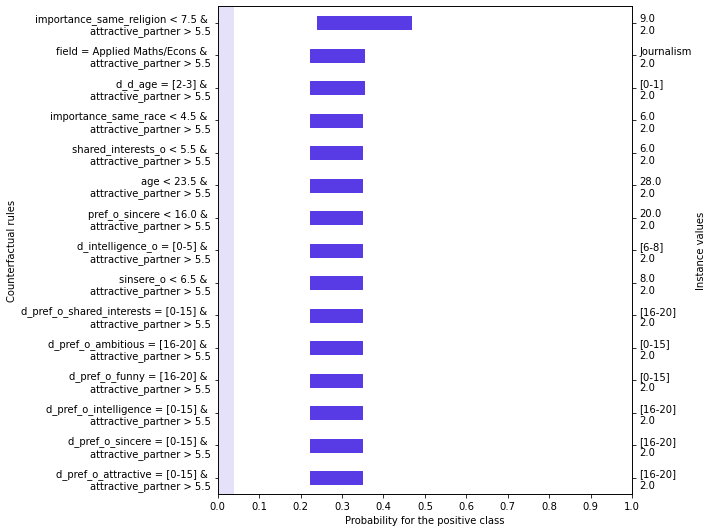

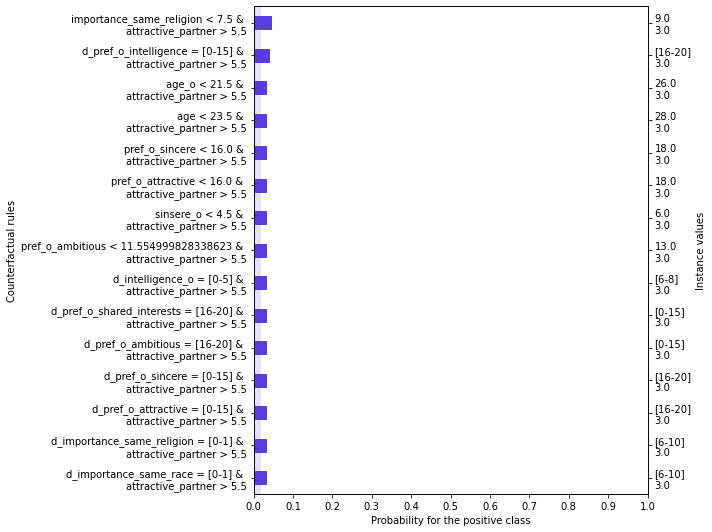

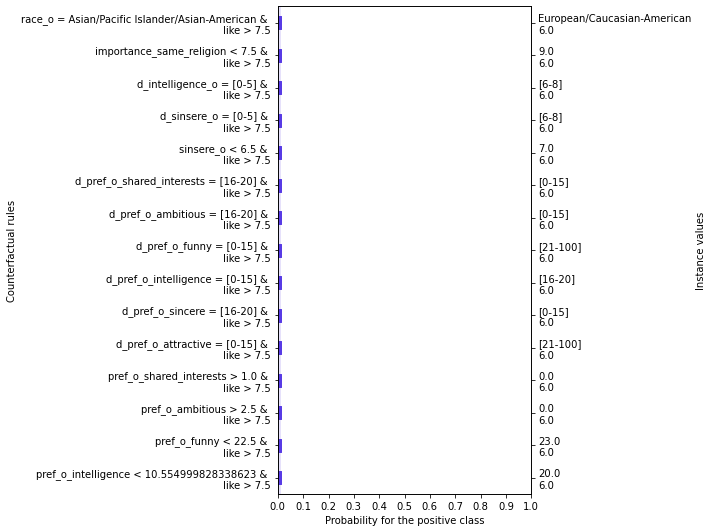

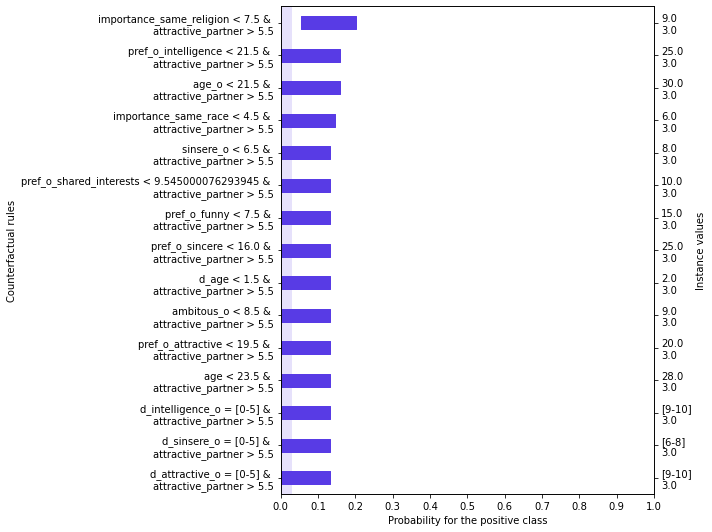

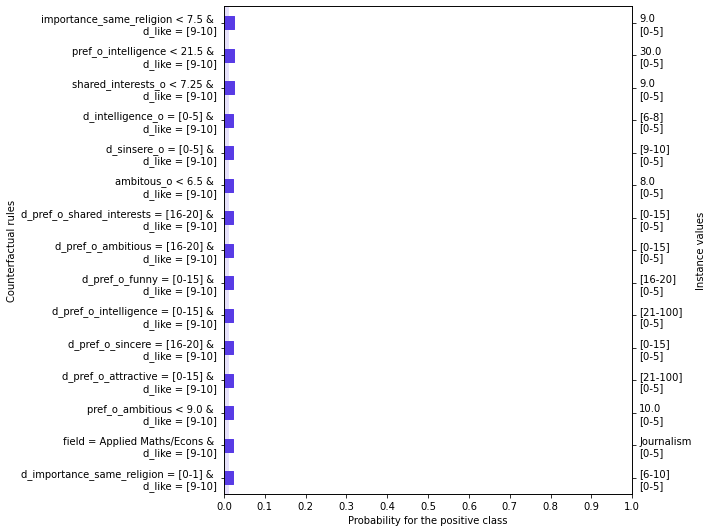

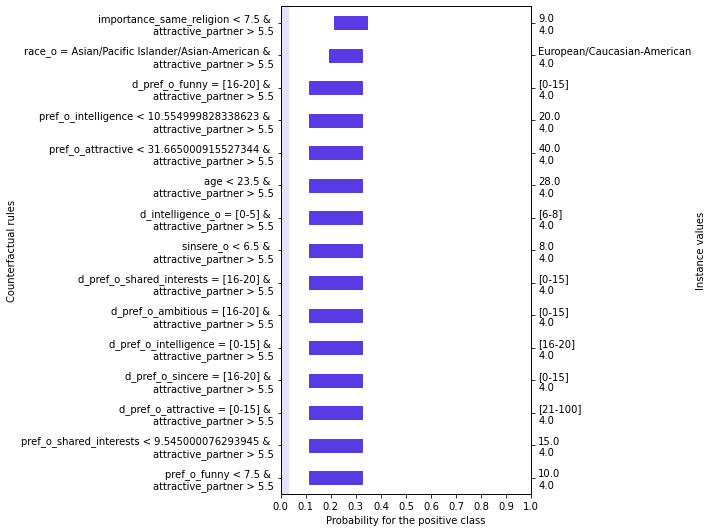

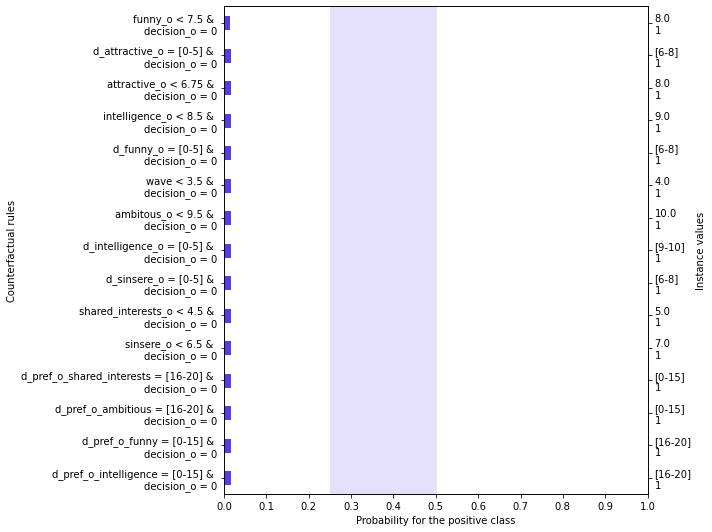

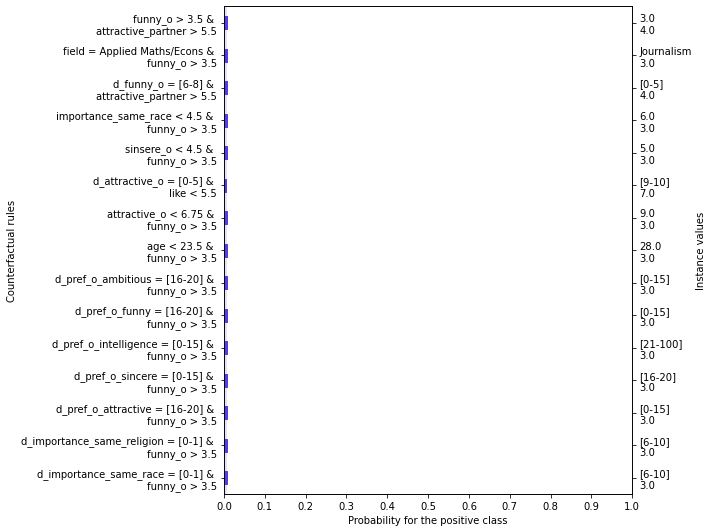

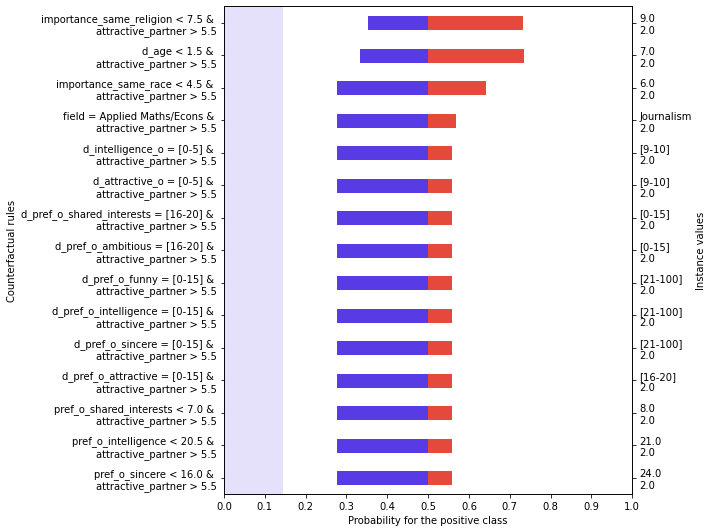

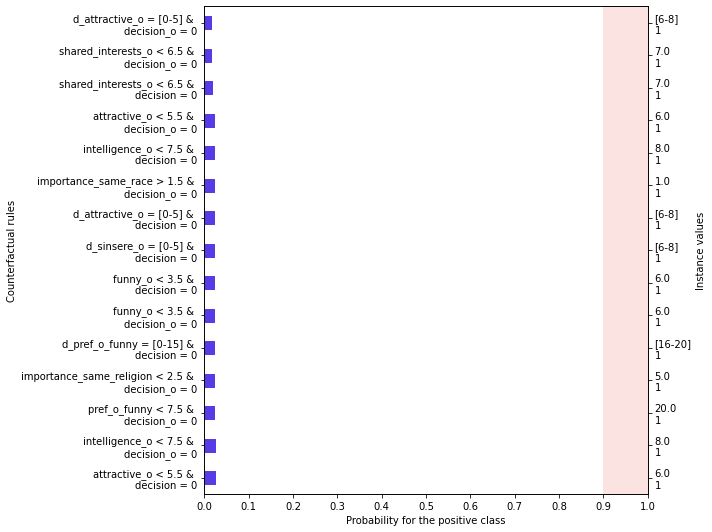

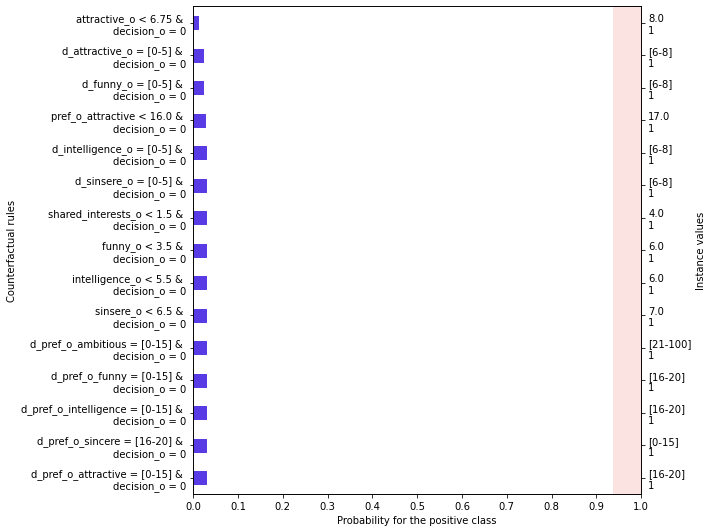

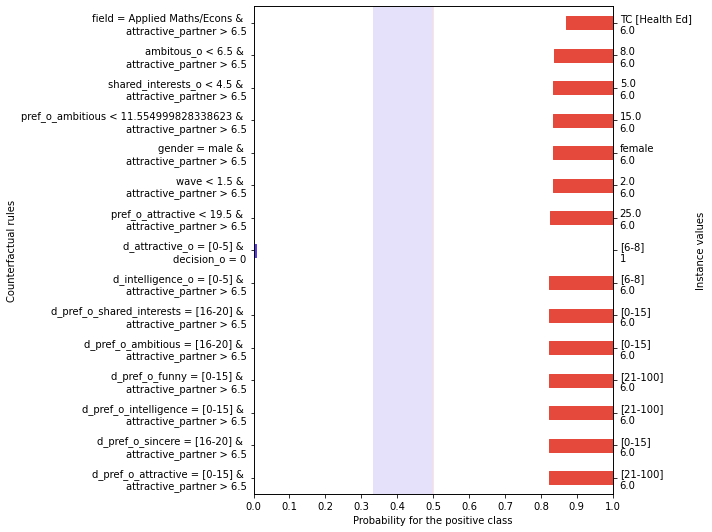

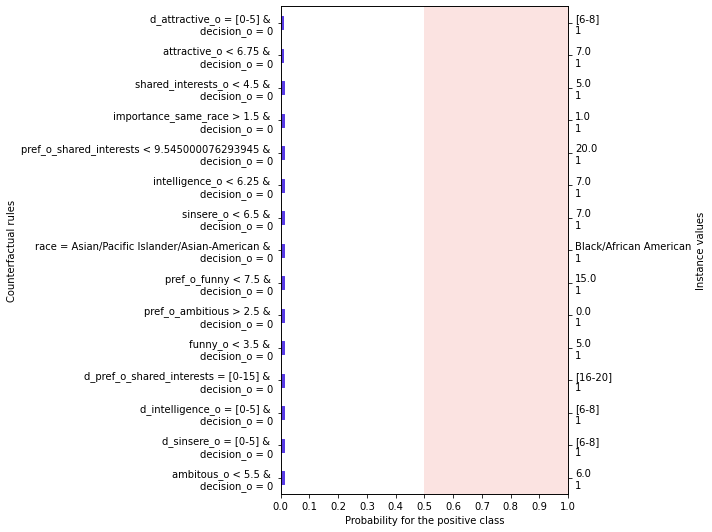

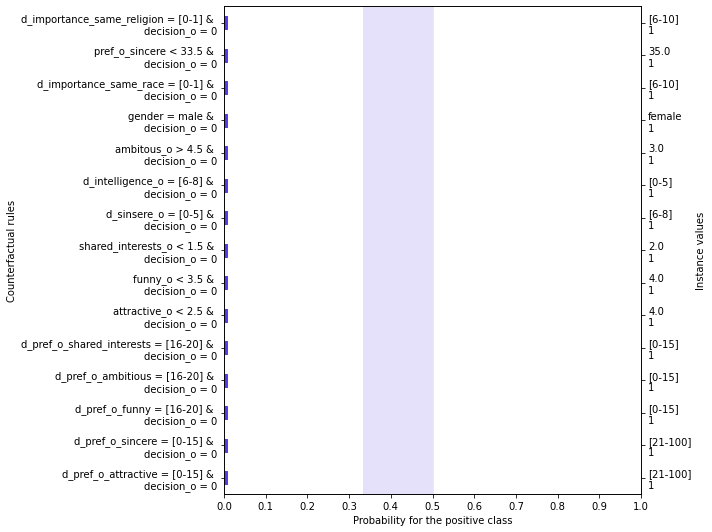

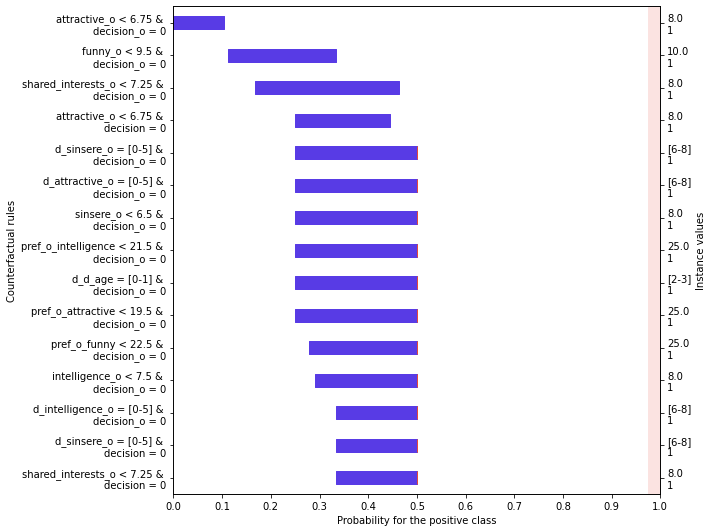

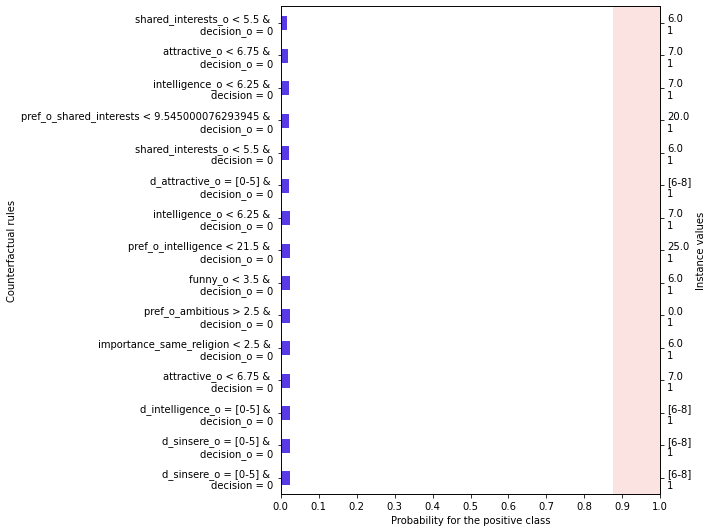

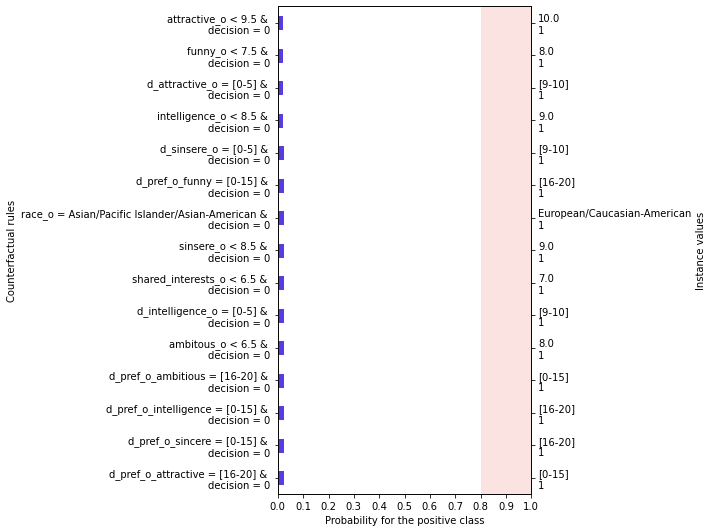

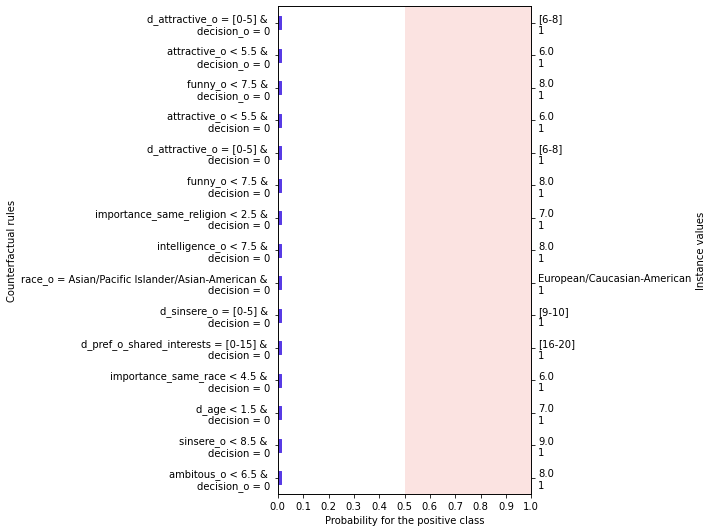

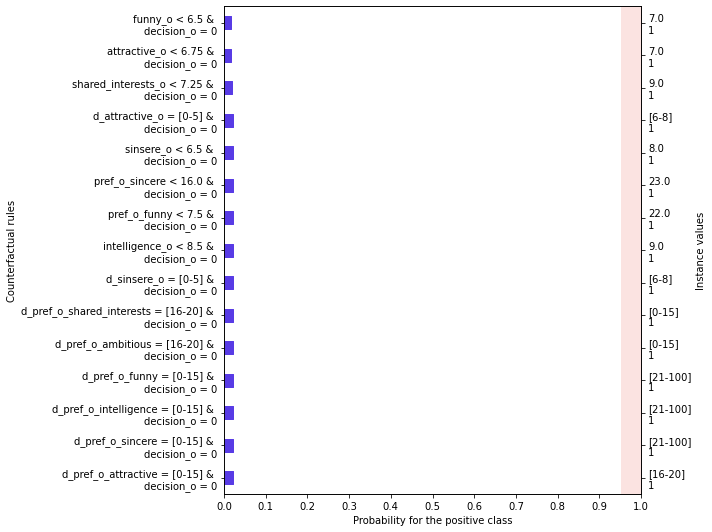

In [10]:
tic = time.time()
counterfactual_explanation.plot_all(n_features_to_show=15)
print(f"Time taken plotting counterfactual rules: {time.time()-tic}")
tic = time.time()
exp = counterfactual_explanation.add_conjunctions()
print(f"Time taken conjunctive rules: {time.time()-tic}")
tic = time.time()
counterfactual_explanation.plot_all(n_features_to_show=15)
print(f"Time taken plotting counterfactual and conjunctive rules: {time.time()-tic}")

In [11]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
print(classification_report(y_test, y_pred, target_names=df[target].unique().astype(str)))
y_va = [int(va > 0.5) for va in counterfactual_explanation.predict['predict']]
print(classification_report(y_test, y_va, target_names=df[target].unique().astype(str)))
print('target, model pred, model prob, va pred, va prob')
print(*zip(y_test, y_pred, y_proba[:,1], y_va, counterfactual_explanation.predict['predict']), sep='\n')

              precision    recall  f1-score   support

           0       0.56      1.00      0.71        10
           1       1.00      0.20      0.33        10

    accuracy                           0.60        20
   macro avg       0.78      0.60      0.52        20
weighted avg       0.78      0.60      0.52        20

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      0.80      0.89        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20

target, model pred, model prob, va pred, va prob
(0, 0, 0.20224109946103444, 0, 0.03125)
(0, 0, 0.21498337504243015, 0, 0.03571428571428571)
(0, 0, 0.14447445699092587, 0, 0.016129032258064516)
(0, 0, 0.084997833001232, 0, 0.007936507936507936)
(0, 0, 0.17581047783374396, 0, 0.025641025641025637)
(0, 0, 0.0927607854952228, 0, 0.0086206896551724